In [9]:
using CairoMakie, Dierckx, QuantEcon, LinearAlgebra, Optim

In [45]:
pars = (;r = 0.04, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 101, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

(r = 0.04, w = 1.0, β = 0.9, γ = 2.0, nz = 19, ρ = 0.9, μ = 0.0, σ = 0.003, na = 101, θ = 4.0, toler = 4.0e-7, maxiter = 1000, how_iter = 50, print_skip = 100, lb = 0.0, ub = 2000.0)

In [60]:
function utility(c, pars)
    (; γ) = pars
    if γ == 1.0
        return log(c)
    else
        return c^(1-γ)/(1-γ)
    end
end

function ar1(pars)
    (;ρ, μ, σ, nz) = pars
    mc = QuantEcon.rouwenhorst(nz, μ, ρ, σ)
    return mc.p, mc.state_values
end

function exp_grid(pars)
    (; na, θ, lb, ub) = pars
    grid = LinRange(0.0,1.0,na)
    exp_grid = lb .+ (ub - lb) .* grid.^θ
    return exp_grid
end

function resources(Avals, Zvals, j, i, pars)
    (; r, w) = pars
    return (1+r)*Avals[j] + ( w * exp(Zvals[i]) )
end

function interpV(Avals, v_slice)
    interp_v = Spline1D(Avals, v_slice, k=3, bc="extrapolate")
    return interp_v
end

function optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
    (; β, na, nz, lb) = pars
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV(Avals, expected_value)
        for j in 1:na
            obj(ap) = - (utility(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))
            ub = resources(Avals, Zvals, j, i, pars)  
            res = optimize(obj, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

function howard(v, policy, Π, Agrid, Zgrid, tuple)
    (; β, na, nz, how_iter) = tuple
    for _ in 1:how_iter
        for j in 1:nz
            exp_val = v * Π[j,:]
            interp_e_val = interpV(Agrid, exp_val)
            for i in 1:na
                obj(ap) = (utility(resources(Agrid, Zgrid, i, j, pars) - ap, pars) + β * interp_e_val(ap))
                v[i,j] = obj(policy[i,j])
            end
        end
    end
    return v
end        

howard (generic function with 2 methods)

Iterating...
--------------------
Iteration: 0, Error: 1.0
--------------------
Iteration: 100, Error: 1.5896171169008212e-5
--------------------
Converged in 139 iterations
--------------------
  2.062363 seconds (2.26 M allocations: 217.610 MiB, 4.64% gc time, 23.77% compilation time)


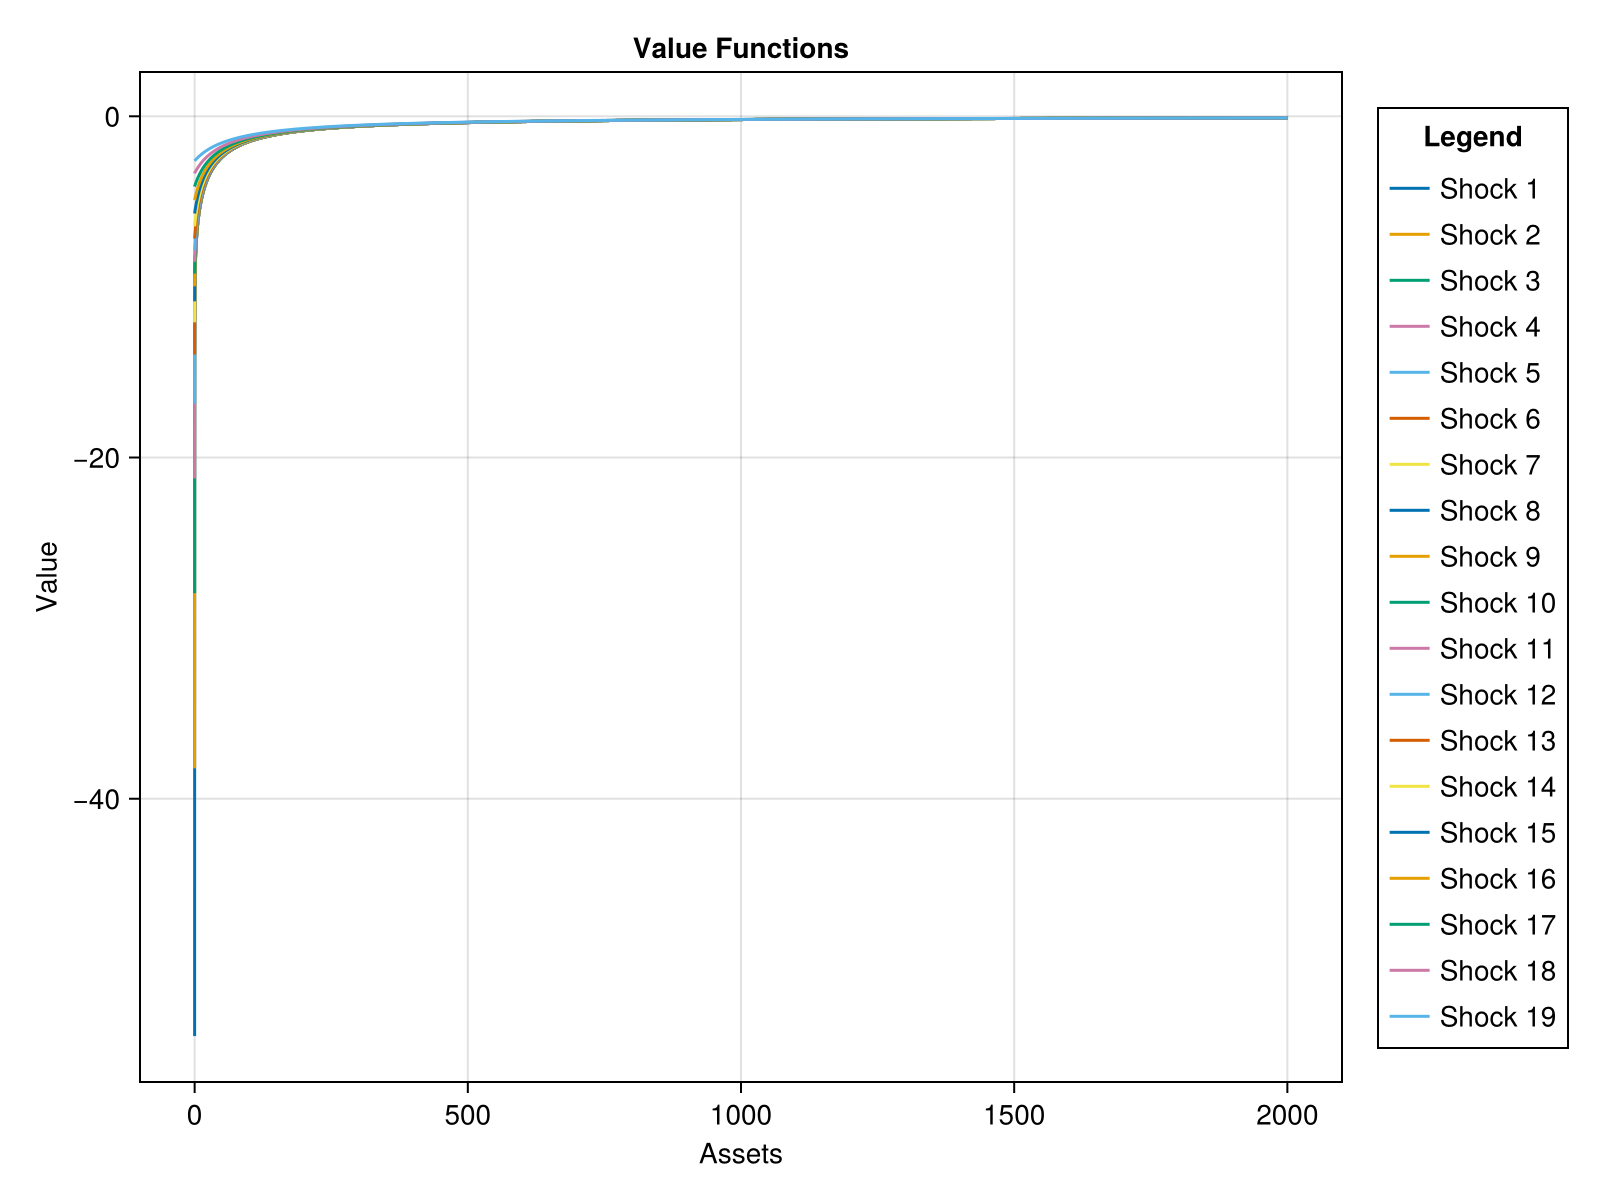

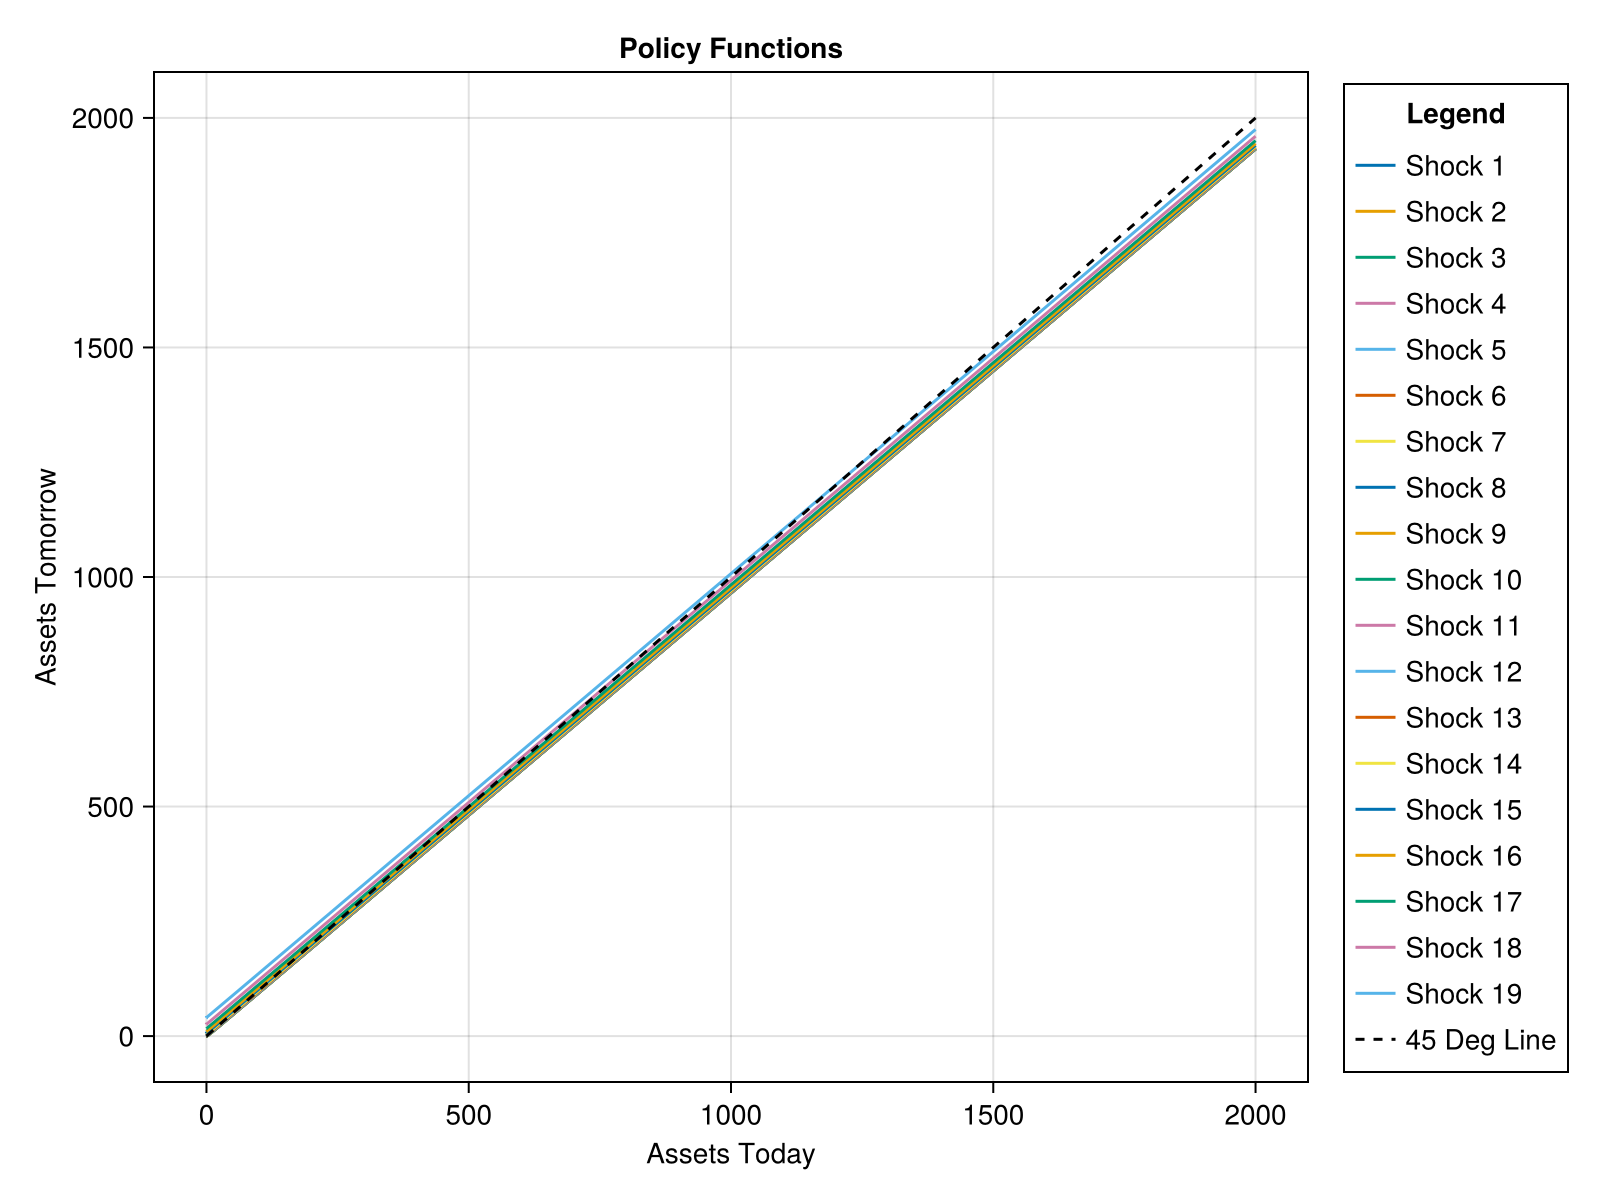

([-53.91132574515686 -38.21645190504183 … -3.3322276107431494 -2.6124963311613563; -53.86850566316585 -38.198117024995895 … -3.332226374996822 -2.612495600052134; … ; -0.10101478063597988 -0.10101420276867985 … -0.09955424855313799 -0.09879880784728386; -0.09710415722604109 -0.0971036233012245 … -0.09575392397987648 -0.09505488367993653], [2.430292874507949e-16 4.40315807012695e-16 … 25.775031878829587 40.333185101163615; 2.434699105112672e-16 4.4058990916226585e-16 … 25.775050999424938 40.333204317288484; … ; 1856.125132841865 1856.1359632284134 … 1883.8969618885865 1898.582685196928; 1932.3601309065784 1932.3709598940716 … 1960.1349721265378 1974.8279108945485])

In [61]:
function vfi(v_init, pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

v_init = ones(pars.na, pars.nz)

@time begin
v_out, pol_out = vfi(v_init, pars)
end

Iterating...
--------------------
Iteration: 0, Error: 3.335302228320124e-6
--------------------
Converged in 2 iterations
--------------------
  1.243322 seconds (2.86 M allocations: 172.528 MiB, 3.99% gc time, 41.15% compilation time)


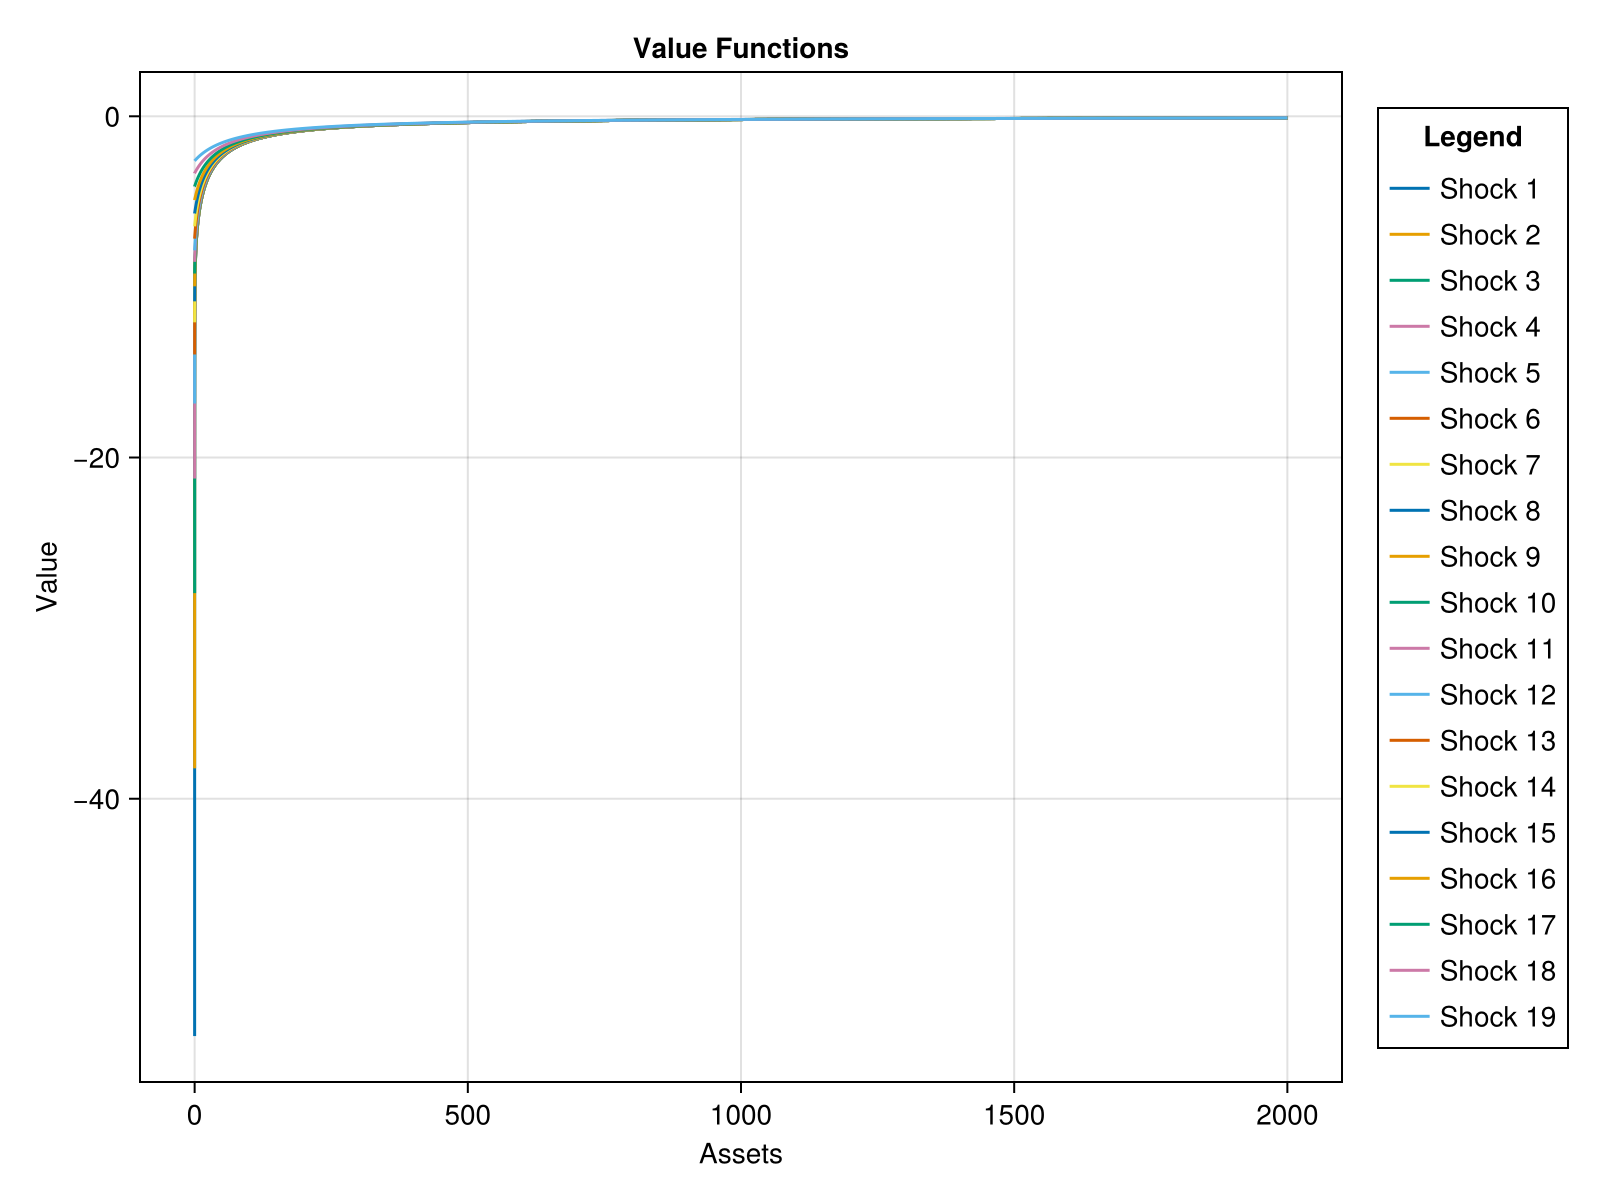

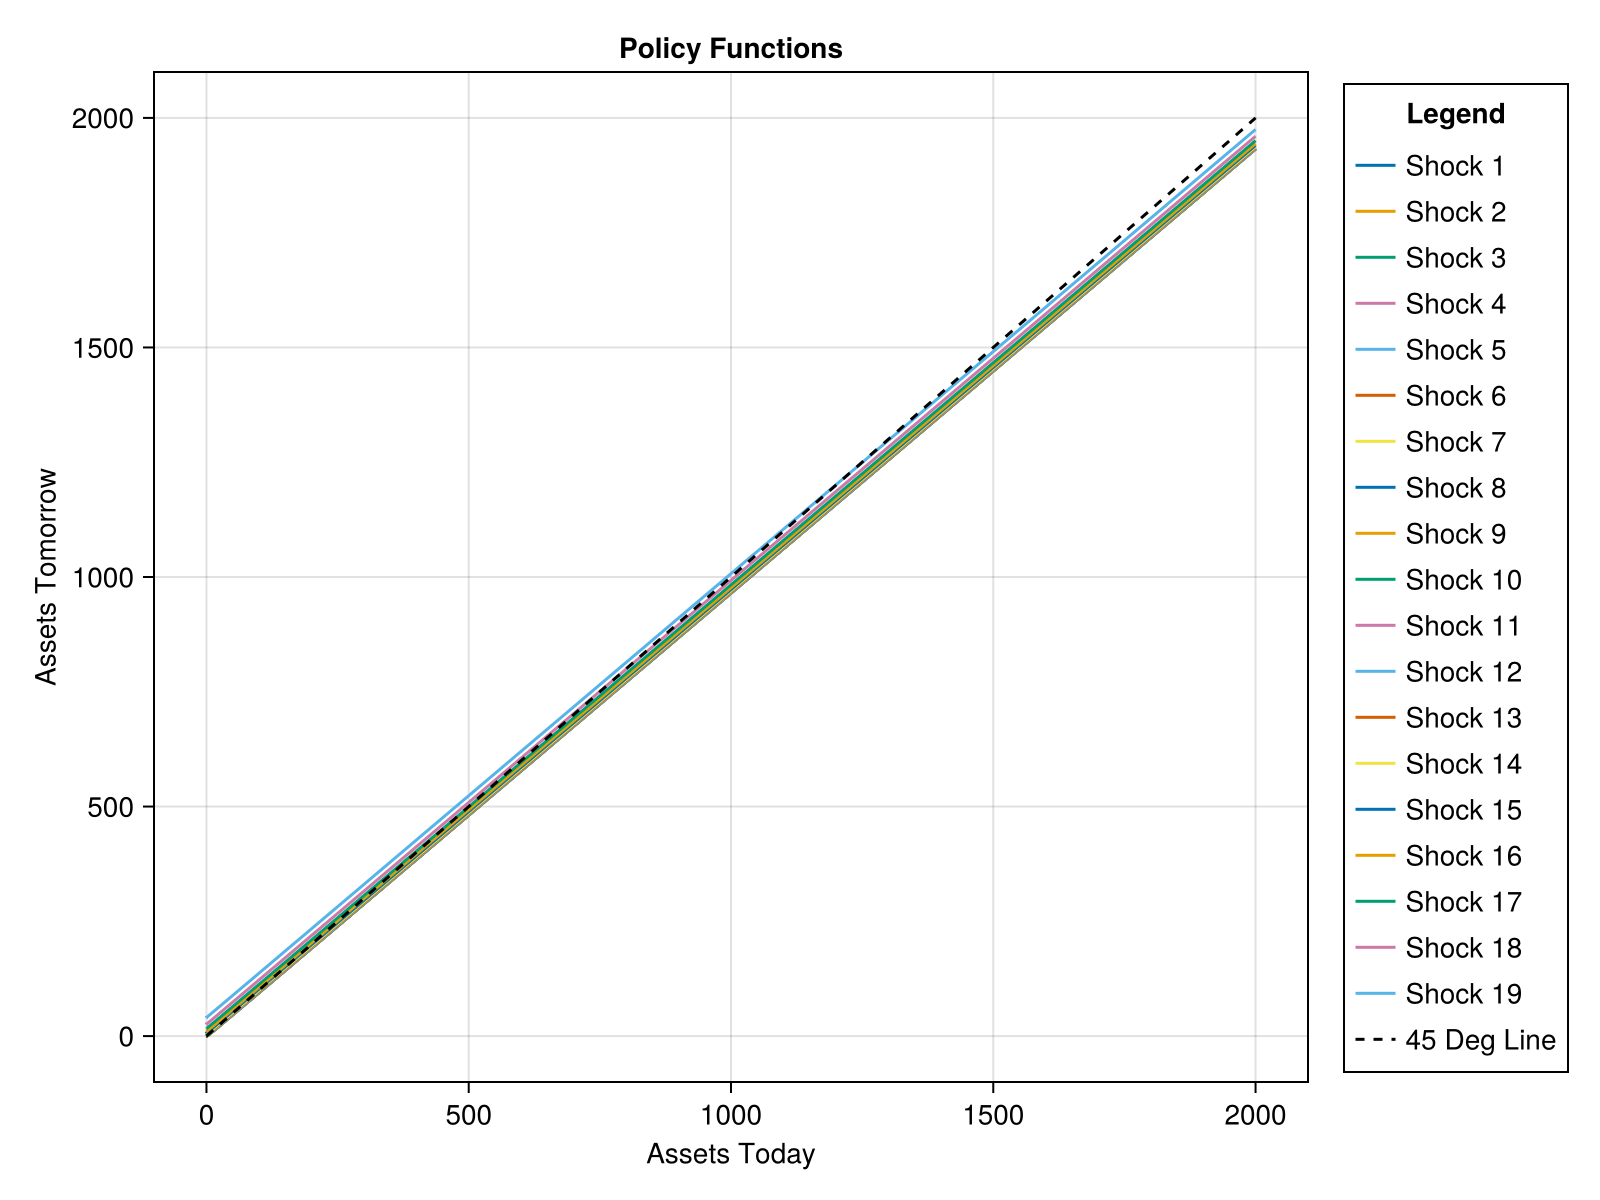

([-53.91132953803983 -38.2164556979248 … -3.3322314036259746 -2.6125001240438936; -53.86850945604881 -38.19812081787886 … -3.332230167879647 -2.612499392934672; … ; -0.10101845181305323 -0.10101787394346093 … -0.09955791377478702 -0.09880246985747163; -0.09710781168860659 -0.09710727776133454 … -0.09575757207006574 -0.0950585283393526], [2.430292874507949e-16 4.403158070126905e-16 … 25.775031878835645 40.33318510114948; 2.434699105112679e-16 4.405899091622637e-16 … 25.775050999425364 40.33320431728256; … ; 1856.1254143482895 1856.1362447441645 … 1883.8972636608728 1898.582998095723; 1932.360470444871 1932.3712994381824 … 1960.1353346789463 1974.8282860260376])

In [62]:
function hpi(v, pol , pars)
    (; maxiter, toler, nz, na, print_skip) = pars
    Π, Zvals = ar1(pars)
    Avals = exp_grid(pars)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise(Avals, Zvals, v_init, v_new, policy, Π, pars)
        v_new = howard(v_new, policy, Π, Avals, Zvals, pars)
        error = maximum(abs.(v_new - v_init) ./ (1 .+ abs.(v_new)))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:pars.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:pars.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end
        
@time begin
    hpi_v, hpi_pol = hpi(v_init, pol_out, pars)
end    

In [48]:
function utility_CES(c, p)
    (; γ) = p
    return c^(1-γ)
end

function interpV_CES(Avals, v_slice, p)
    (; γ) = p
    interp_v = Spline1D(Avals, v_slice, k=1, bc="extrapolate")
    transformed_interp(x) = interp_v(x)^(1.0-p.γ)
    return transformed_interp
end

function optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
    (; β, na, nz, lb, γ) = p
    for i in 1:nz
        expected_value = v_init * Π[i,:]
        interpolation = interpV_CES(Avals, expected_value, p)
        for j in 1:na
            obj_CES(ap) = - (((1-β) * utility_CES(resources(Avals, Zvals, j, i, pars) - ap, pars) + β * interpolation(ap))^(1/(1-γ)))
            ub = resources(Avals, Zvals, j, i, p)  
            res = optimize(obj_CES, lb, ub)
            policy[j,i] = res.minimizer
            v_new[j,i] = -res.minimum
        end
    end
    return v_new, policy
end

optimise_CES (generic function with 1 method)

Iterating...
--------------------
Iteration: 0, Error: 0.8161556844308419
--------------------
Iteration: 100, Error: 0.02926767212321124
--------------------
Iteration: 200, Error: 7.123445726620048e-7
--------------------
Converged in 207 iterations
--------------------
  5.529394 seconds (122.58 M allocations: 2.510 GiB, 3.56% gc time, 3.60% compilation time)


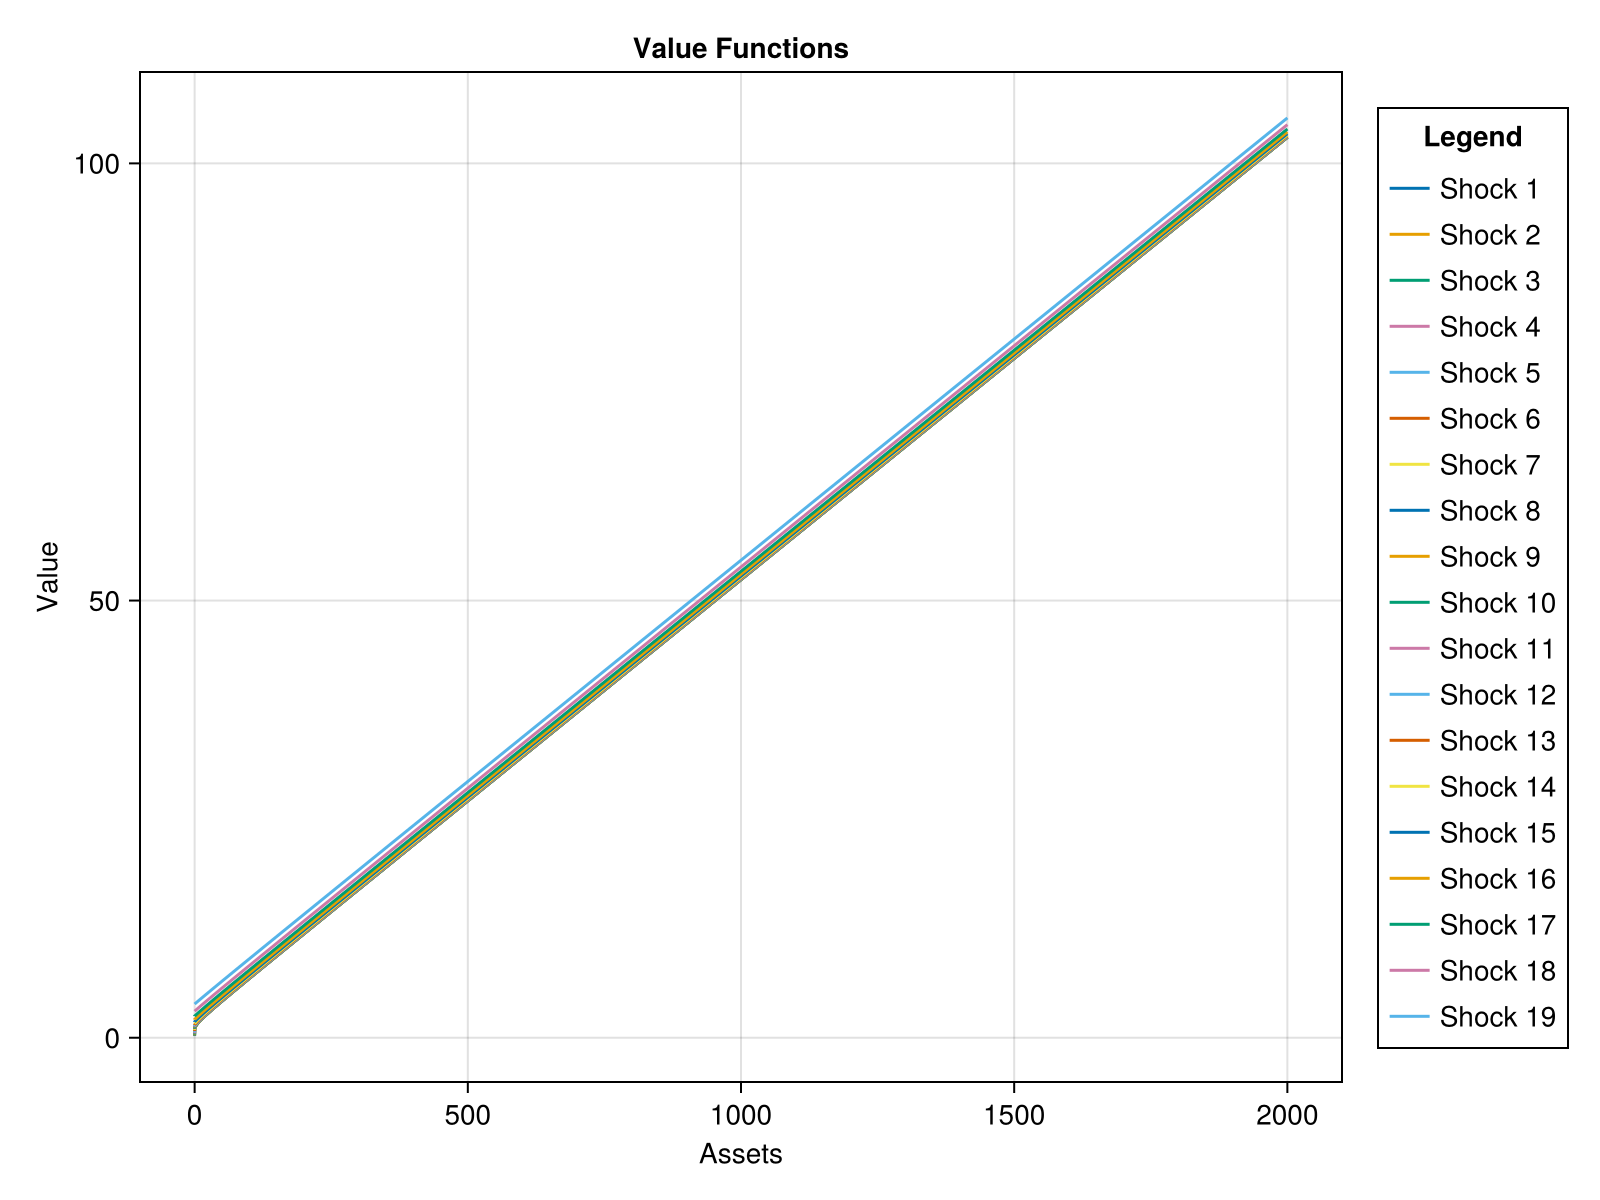

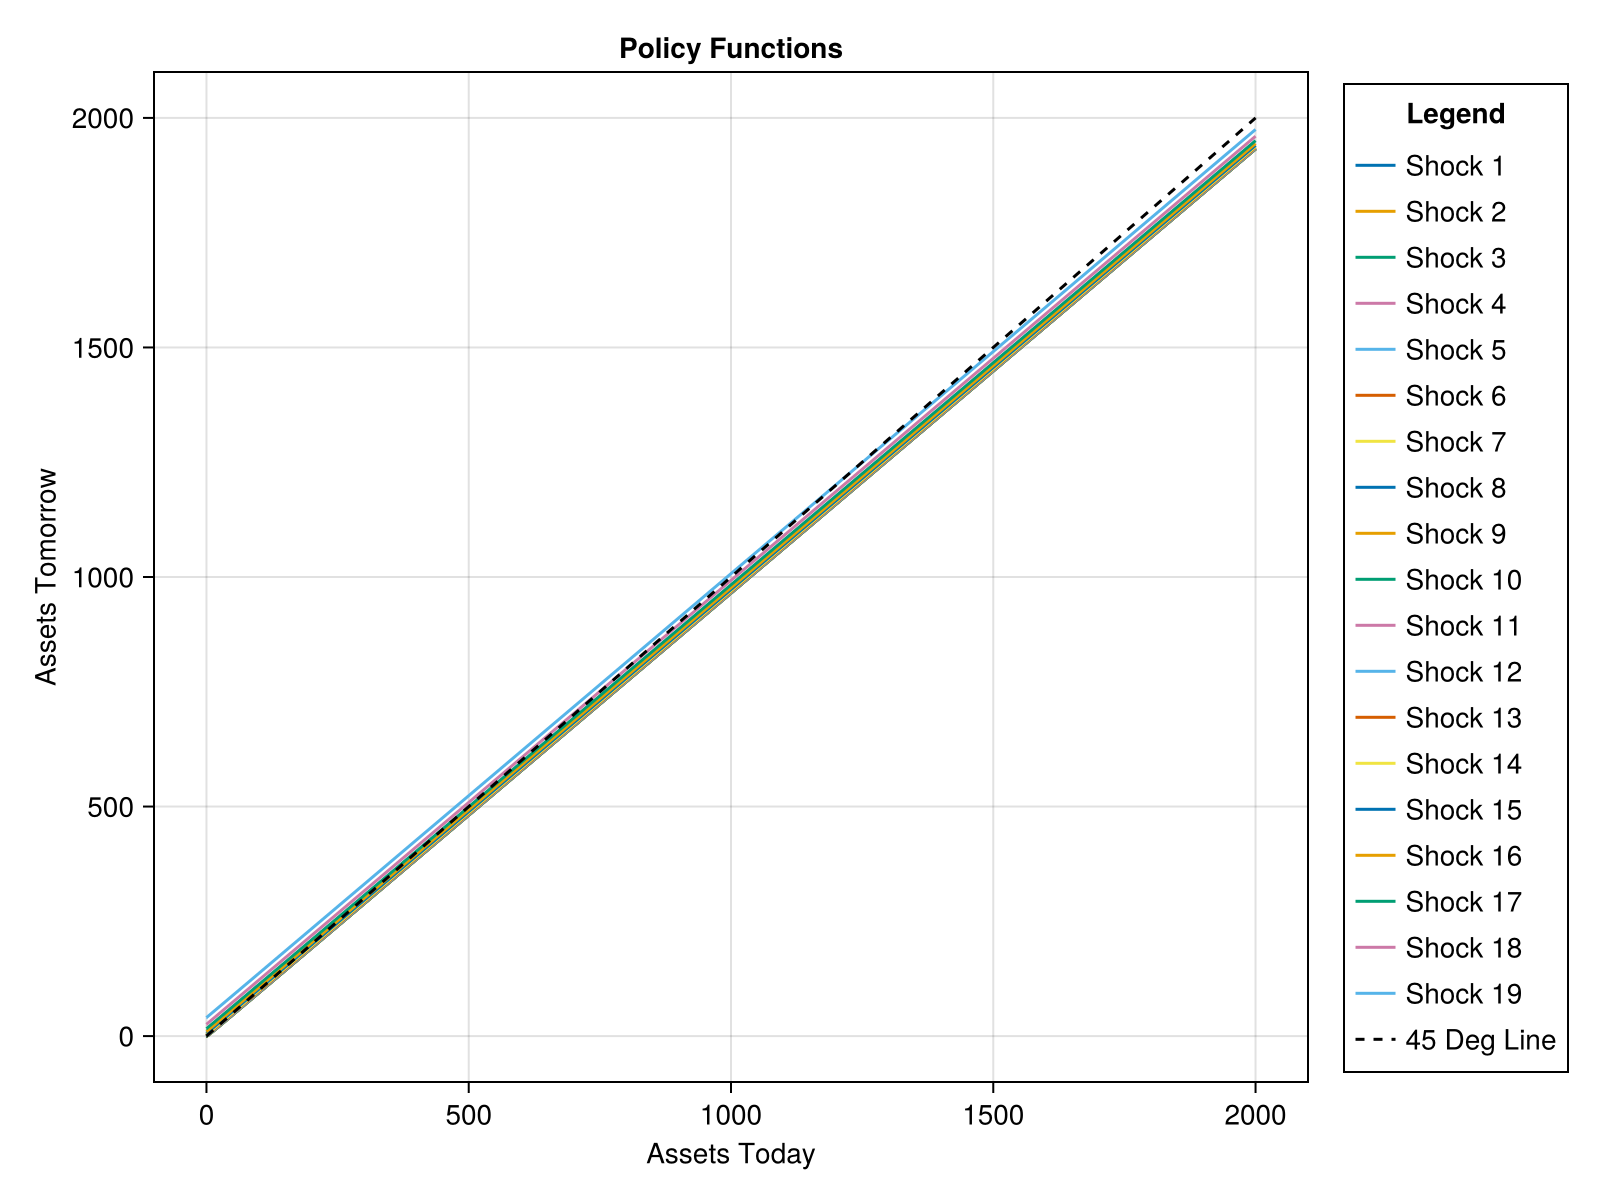

([0.18858684152588295 0.2678732026213222 … 3.0371555621402813 3.855671661955868; 0.2070952514534045 0.2838761743267178 … 3.0372896080610974 3.8558024309284673; … ; 90.15060839255463 90.15117465511226 … 91.60280493879489 92.37080648198214; 102.98041513759894 102.98098138728817 … 104.4325786824124 105.20056277262691], [3.5181593885267114e-16 3.200489815799136e-16 … 25.67402744625178 40.26400770455533; 3.9600757145084753e-16 3.605831793078348e-16 … 25.676409816690413 40.2663923568542; … ; 1686.988225008752 1686.9990548585115 … 1714.761682359834 1729.4498168517614; 1932.3628861201692 1932.3737159760565 … 1960.1363627998812 1974.824507408137])

In [50]:
function vfi_CES(v_init, p)
    (; maxiter, toler, nz, na, print_skip) = p
    Π, Zvals = ar1(p)
    Avals = exp_grid(p)
    v_new = similar(v_init)
    policy = similar(v_init)
    error = toler + 1
    iter = 0
    if iter == 0
        println("Iterating...")
    end
    while ((error > toler) && (iter < maxiter))
        v_new, policy = optimise_CES(Avals, Zvals, v_init, v_new, policy, Π, p)
        error = maximum(abs.(v_new - v_init))
        v_init .= v_new
        if iter % print_skip == 0
            println("--------------------")
            println("Iteration: $iter, Error: $error")
        end
        iter += 1
    end
    println("--------------------")
    println("Converged in $iter iterations")
    println("--------------------")

    fig1 = Figure(size = (800, 600))
    ax1 = Axis(fig1[1, 1], title = "Value Functions", xlabel = "Assets", ylabel = "Value")
    for j in 1:p.nz
        lines!(ax1, Avals, v_new[:,j], label = "Shock $j")
    end
    legend = Legend(fig1[1,2], ax1, "Legend", orientation = :vertical, fontsize = 4)
    display(fig1)

    fig2 = Figure(size = (800, 600))
    ax2 = Axis(fig2[1, 1], title = "Policy Functions", xlabel = "Assets Today", ylabel = "Assets Tomorrow")
    for j in 1:p.nz
        lines!(ax2, Avals, policy[:,j], label = "Shock $j")
    end
    lines!(ax2, Avals, Avals, label = "45 Deg Line", color = :black, linestyle = :dash)
    legend = Legend(fig2[1,2], ax2, "Legend", orientation = :vertical, fontsize = 4)
    display(fig2)

    return v_new, policy

end

p = (;r = 0.04, # interest rate
    w = 1.0, # wage
    β = 0.9, # discount factor
    γ = 2.0, # risk aversion
    nz = 19, # number of grid points for z
    ρ = 0.9, # persistence of AR1
    μ = 0.0, # mean of AR1
    σ = 0.003, # std of AR1
    na = 31, # number of asset grid points
    θ = 4.0, # grid expansion factor
    toler = 4e-7, # tolerance
    maxiter = 1000, # maximum no. of iterations
    how_iter = 50, # number of Howard iterations
    print_skip = 100, # how often to print
    lb = 0.0, # lower bound of capital grid
    ub = 2000.0) # upper bound of capital grid

v2 = ones(p.na, p.nz)

@time begin
v_out, pol_out = vfi_CES(v2, p)
end